In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale = 2.5) # seborn style로 그리고, font size따로 지정 대신 font_scale로 일괄 지정

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\이정진\AppData\Local\Temp\ipykernel_20512\2776985437.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


전체 프로세스  
1. 데이터셋 확인 - 결측치의 존재 확인 후 향후 수정
2. EDA - 여러 feature를 개별적으로 분석, 상관관계 확인을 통해 insight를 얻는다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 engineering. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 한다.
4. modeling - sklearn을 사용해 모델을 만든다.
5. train, predict
6. 평가 - 예측 성능이 원하는 수준인지 판단한다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다. 학습된 모델이 어떤것을 학습하였는지 확인한다.

# 1. Dataset 확인

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived를 예측하고자 함

In [3]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

|Feature|Definition|Description|type|
|:------|:---:|:-------------:|:--:|
|Survived|생존여부|target label임. 0 or 1|integer|
|Pclass|티켓의 클래스|1,2,3등급으로 나뉘며 categorical|integer|
|Sex|성별|male/female|string|
|Age|나이|countinuous|integer|
|SibSp|함께 탑승한 형제와 배우자의 수|quantitative|integer|
|Parch|함께 탑승한 부모, 아이의 수|quantitative|integer|
|Ticket|티켓번호|alphabet + integer|string|
|Fare|탑승료|continuous|float|
|Cabin|객실번호|alphabet+integer|string|
|Embarked|탑승항구|C,Q,S|string|


In [4]:
# 각 피처의 통계치 반환
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


고유값인 PassengerId와 숫자가 안맞는 것을 보아 결측값이 존재함을 알 수 있음

## 1.1 Null data check

In [6]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100
        * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)   

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [7]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100
        * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)   

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


train, test 데이터셋 둘다 Age에서 약 20%, Cabin에서 약 78%의 결측치가 존재하는 것을 볼 수 있다.

<Axes: >

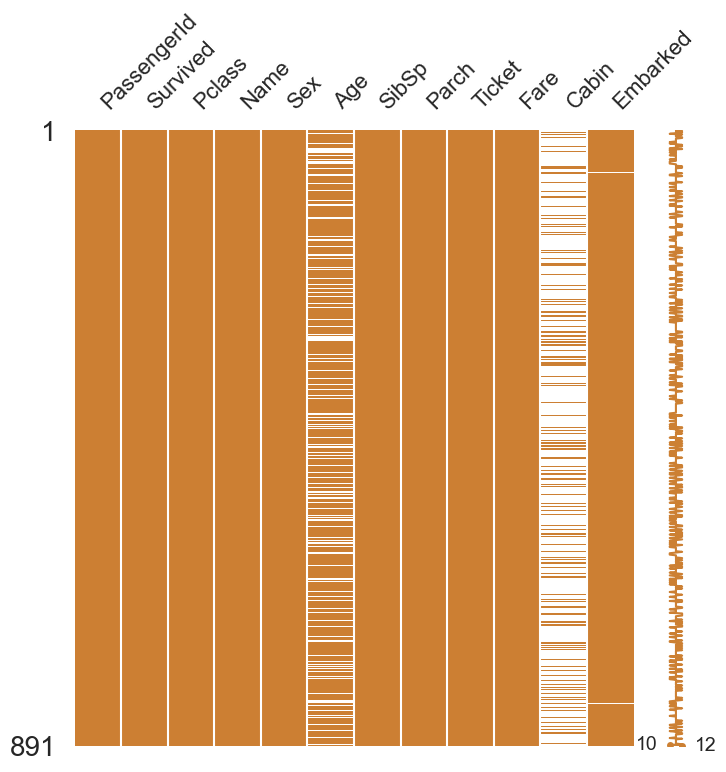

In [8]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8), color=(0.8, 0.5,0.2))

<Axes: >

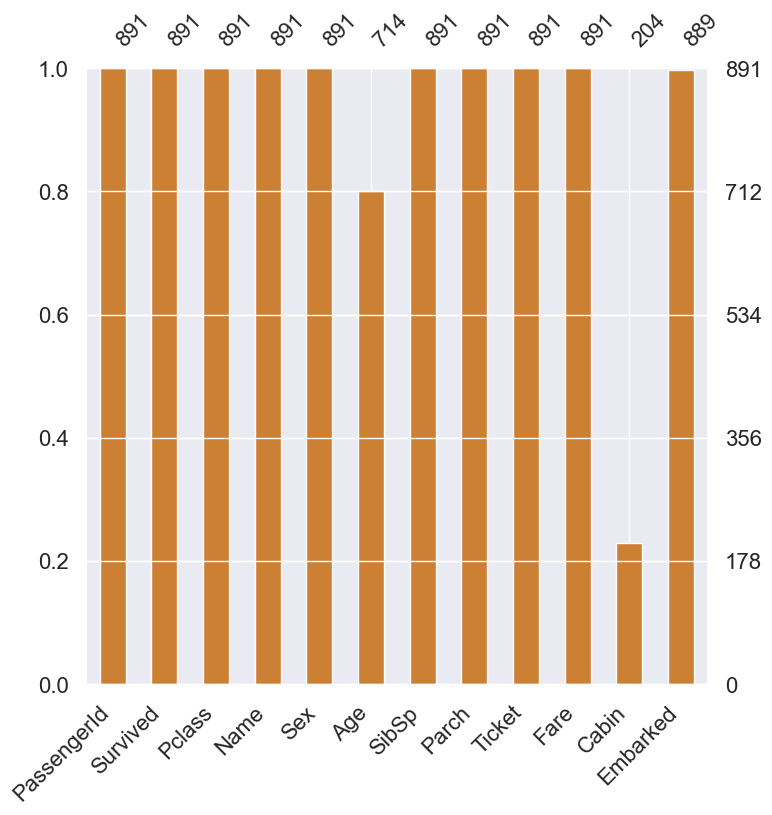

In [9]:
msno.bar(df=df_train.iloc[:,:],figsize=(8,8),color=(0.8,0.5,0.2))

## 1.2 Target Label 확인
* target label이 어떤 분포를 가지고 있는지 확인
* binary classification 문제의 경우 0,1의 분포에 따라 모델의 평가 방법이 달라질 수 있다.

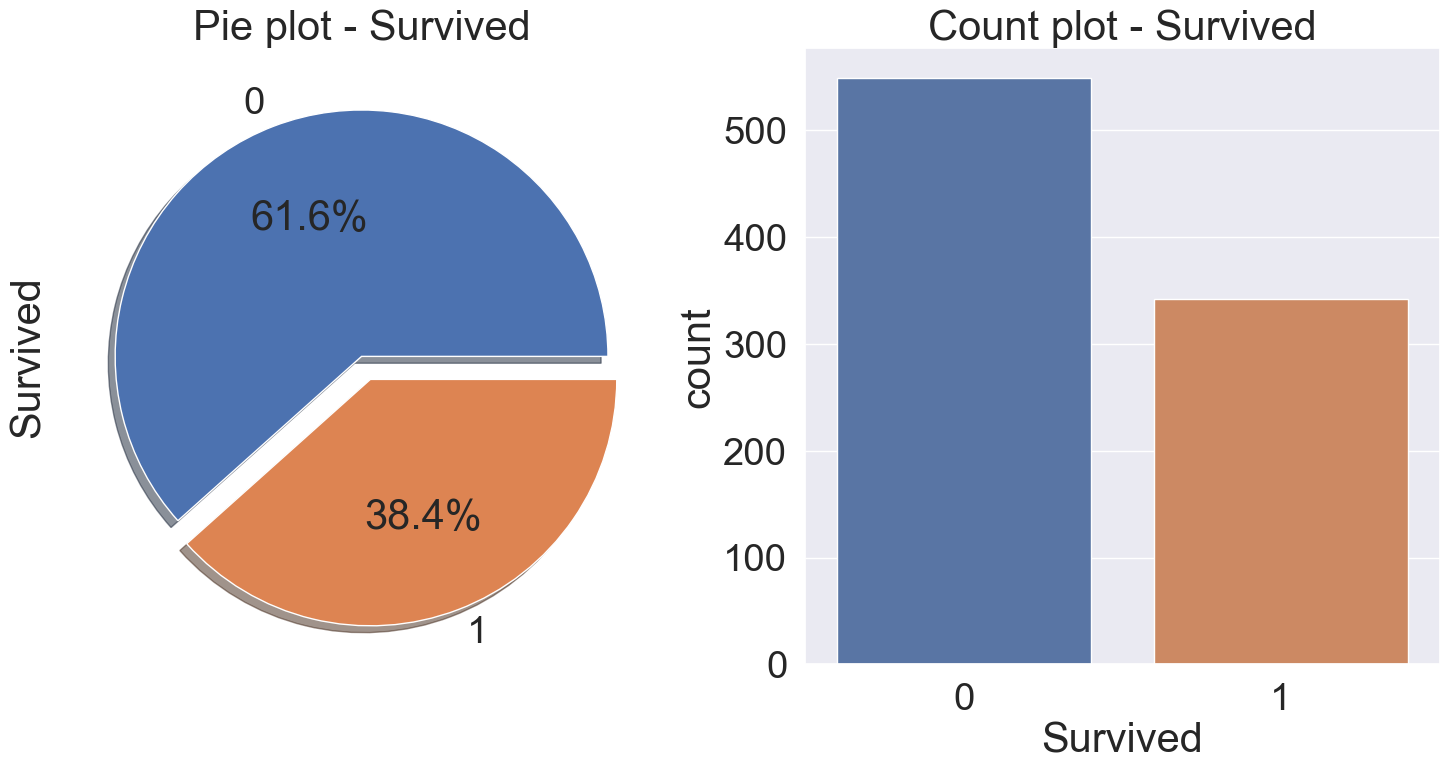

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train['Survived'].value_counts().plot.pie(explode=[0,0.1],
                                             autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_label('')
sns.countplot(x='Survived',data=df_train, ax=ax[1]) # x=을 붙여줘야함
ax[1].set_title('Count plot - Survived')
plt.show()

* 죽은 사람이 61.6%로 더 많다.
* target label의 분포가 많이 unbalanced하진 않다. 만약 0과 1의 분포가 차이가 많이 난다면 모델학습이 잘 되지 않는다.

# EDA(Exporatory data analysis)

## 2.1 Pclass
* Pclass는 ordinal(순서형)데이터이다.
* Pclass에 따른 생존률의 차이를 살펴보기 위해 피벗차트와 같은 groupby를 사용.
* Pclass와 Survived를 Pclass별로 생존여부를 본다.

In [11]:
df_test[['Pclass','Survived']].groupby('Pclass', as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [12]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


pandas의 crosstab을 이용하면 위 과정이 좀더 쉽다.

In [13]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


grouped 객체에 mean()을 하게 되면 각 클래스별 생존률을 얻을 수 있다.  
class 1의 경우 $\frac{80}{(80+136)} \approx 0.63$

<Axes: xlabel='Pclass'>

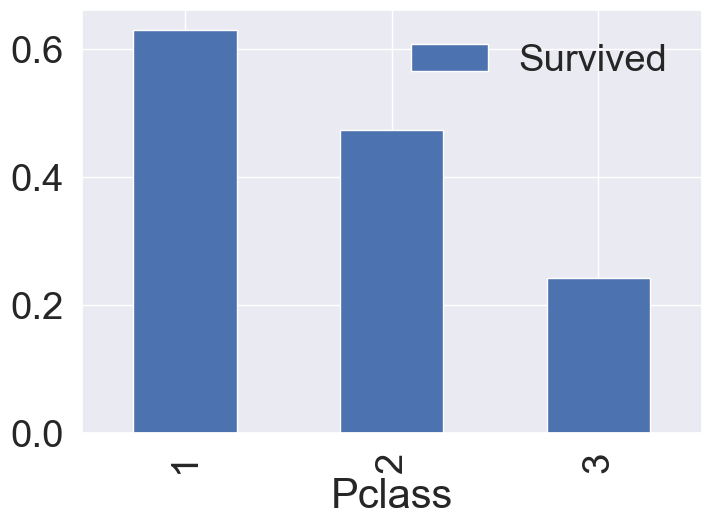

In [14]:
df_train[['Pclass','Survived']].\
    groupby('Pclass', as_index=True).\
    mean().\
    sort_values(by='Survived', ascending=False).plot.bar()


* Pclass가 좋을수록(1st) 생존률이 높다.
* 좀더 보기 쉽게 sns.countplot으로 특정 label에 따른 개수 그리기

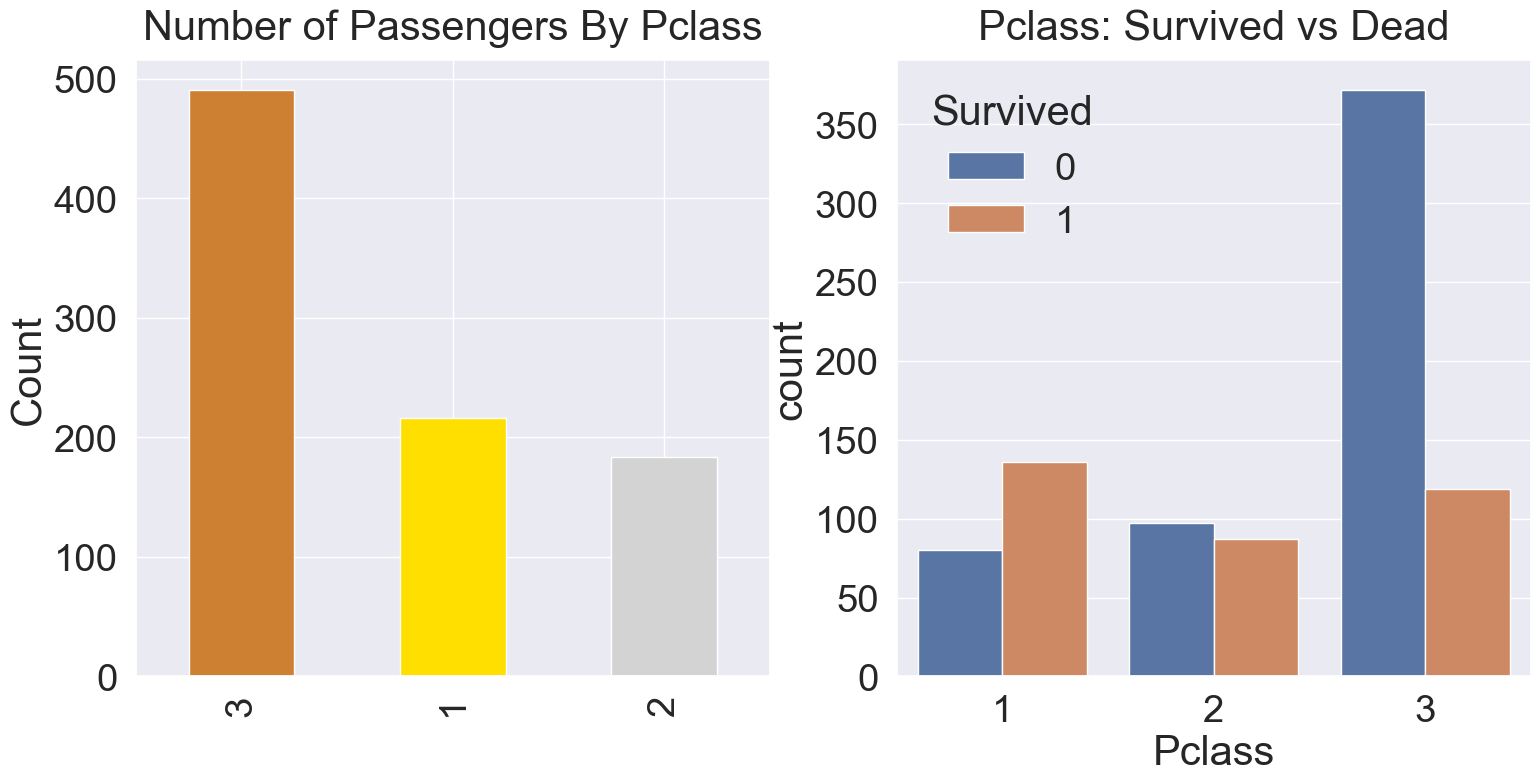

In [15]:
y_position = 1.02 #title의 위치 조정 default=1 값이 클수록 위로 표시됨
f, ax = plt.subplots(1,2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],
                                           ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y = y_position)
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass', hue='Survived', data=df_train, ax=ax[1]) # x=을 붙여줘야함
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

* 클래스가 높을수록 생존 확률이 높은 것을 알 수 있다. 1,2,3 순서대로 63%, 48%, 25%이다.
* 생존에 Pclass가 큰 영향을 미친다고 생각해 볼 수 있으며, ㅏㄴ중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단 가능.

## 2.2 Sex
* 이번에는 성별로 생존률이 어떻게 달라지는지 확인

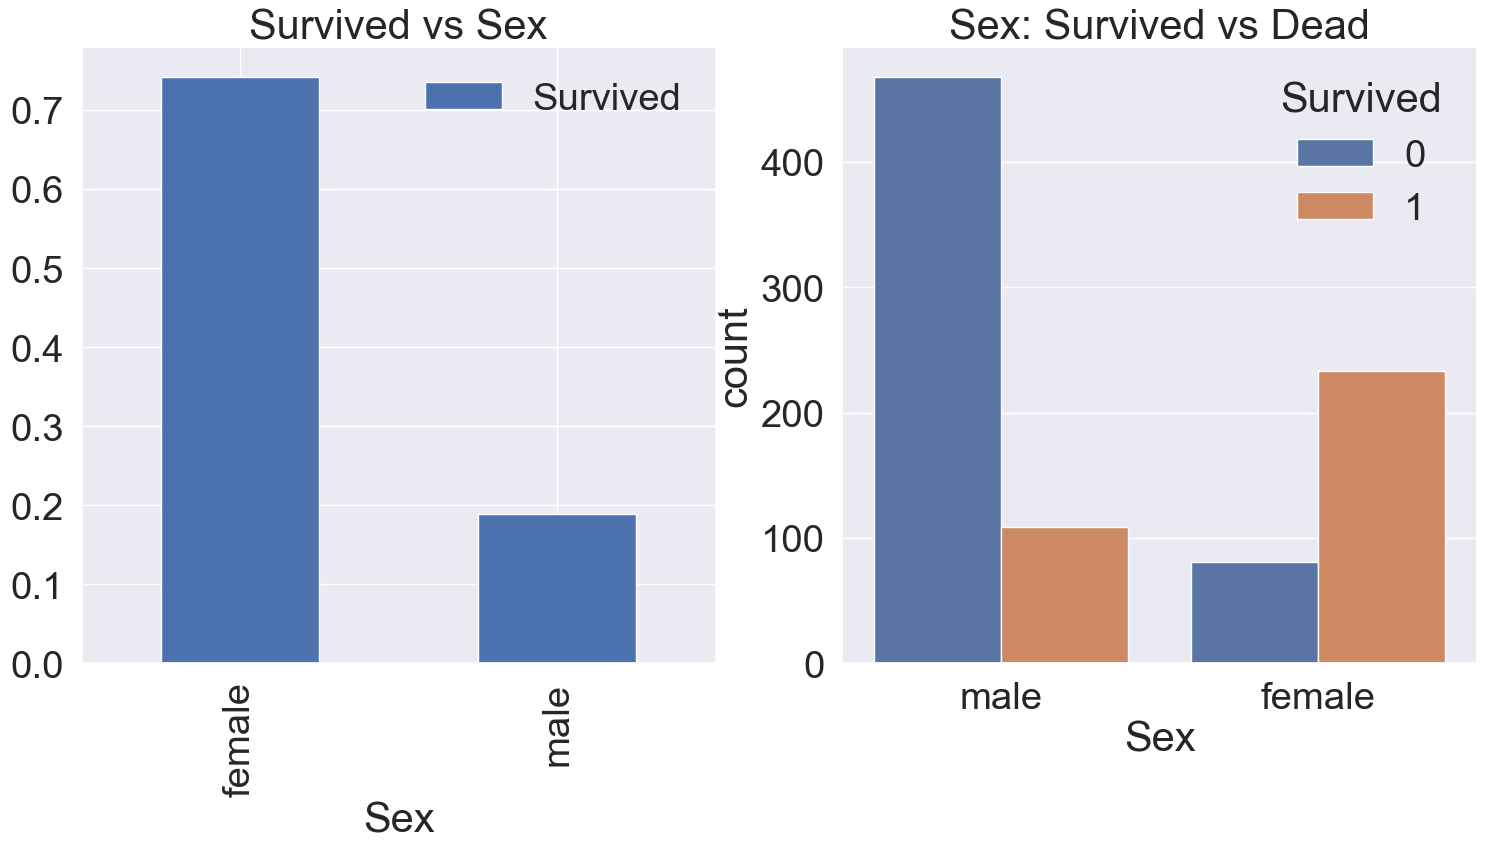

In [16]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby('Sex', as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

* 여자가 생존할 확률이 높다.

In [17]:
df_train[['Sex', 'Survived']].groupby('Sex', as_index=True).\
                              mean().\
                              sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [18]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


* Pclass와 마찬가지로 Sex도 예측모델에 쓰일 중요한 feature임을 알 수 있다.

## Both Sex and Pclass
* 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는지 확인
* seaborn의 factorplot을 이용하면, 손쉽게 3차원으로 이루어진 그래프를 그릴 수 있다.

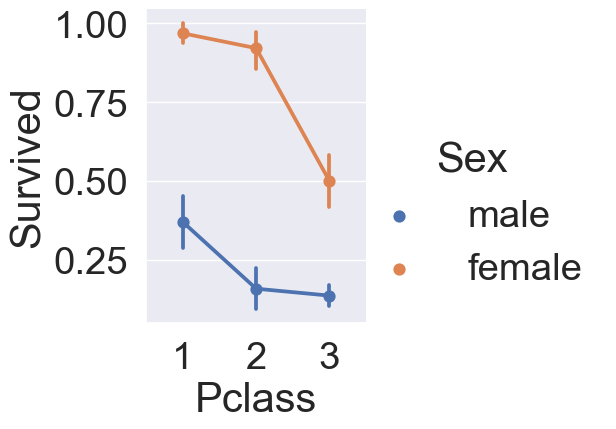

In [19]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=df_train, kind='point') # factorplot은 사라짐
# kind에는 strip(default), swarm, box, violin, boxen, point, bar, count가 있다. 각각 ex violinplot()으로 사용 가능.

* 모든 클래스에서 female이 살 확률이 male이 살 확률보다 높다.
* 남자 여자 모두 클래스가 낮을수록 살 확률이 낮다.
* hue 대신 column으로 옵션을 주면 아래와 같은 그래프가 나온다.

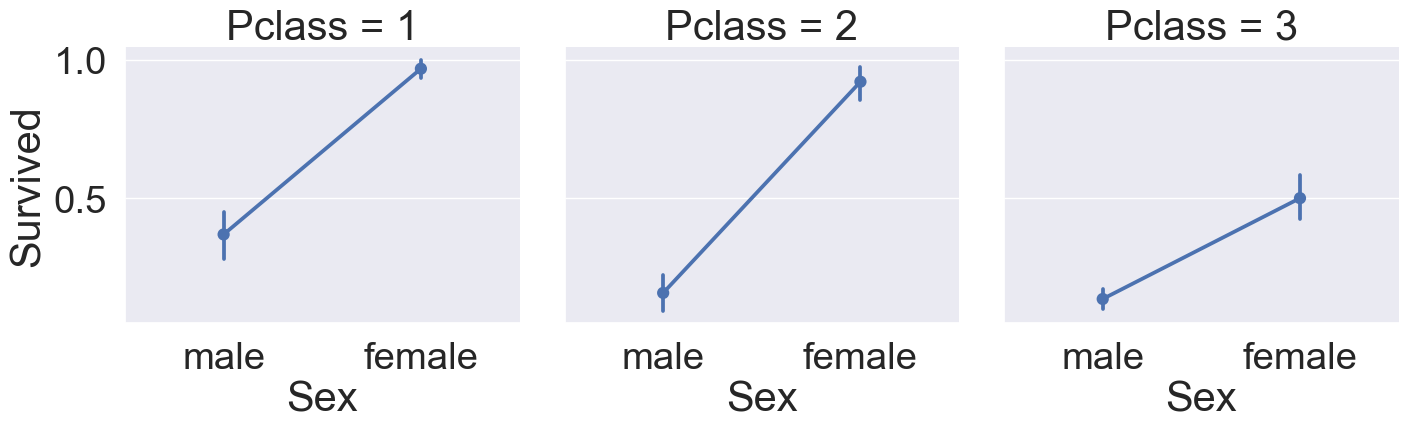

In [20]:
sns.catplot(x='Sex', y='Survived', col='Pclass' ,data=df_train, kind='point') # factorplot은 사라짐

## 2.4 Age

In [21]:
# Age 통계량
print('제일 나이 많은 탑승객: {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객: {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이: {:.1f} Years'.format(df_train['Age'].mean()))


제일 나이 많은 탑승객: 80.0 Years
제일 어린 탑승객: 0.4 Years
탑승객 평균 나이: 29.7 Years


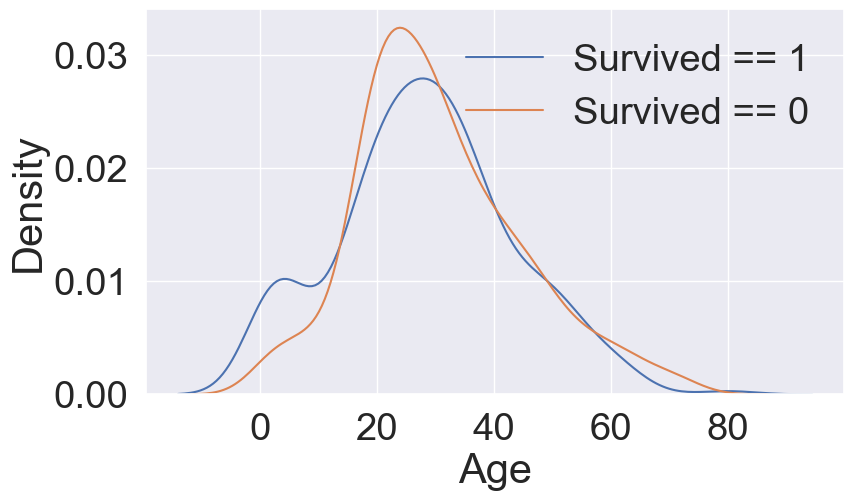

In [22]:
# 생존에 따른 Age의 histogram
fig, ax = plt.subplots(1, 1, figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

생존자 중 나이가 어린 경우가 많음

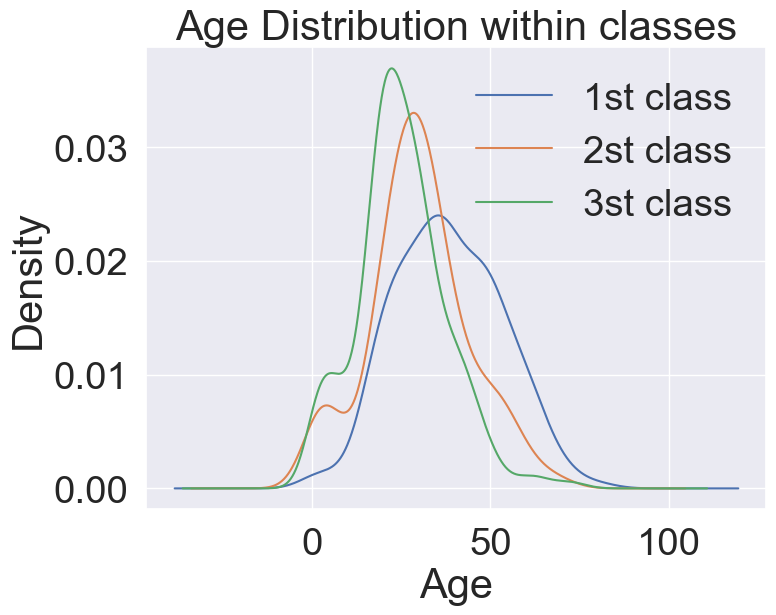

In [23]:
# Age distribution within classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass']==1].plot(kind='kde')
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st class','2st class','3st class'])

* Class가 높을수록(3->1) 나이 많은 사람의 비중이 커진다.
* 나이대를 넓혀가며 생존률을 보자

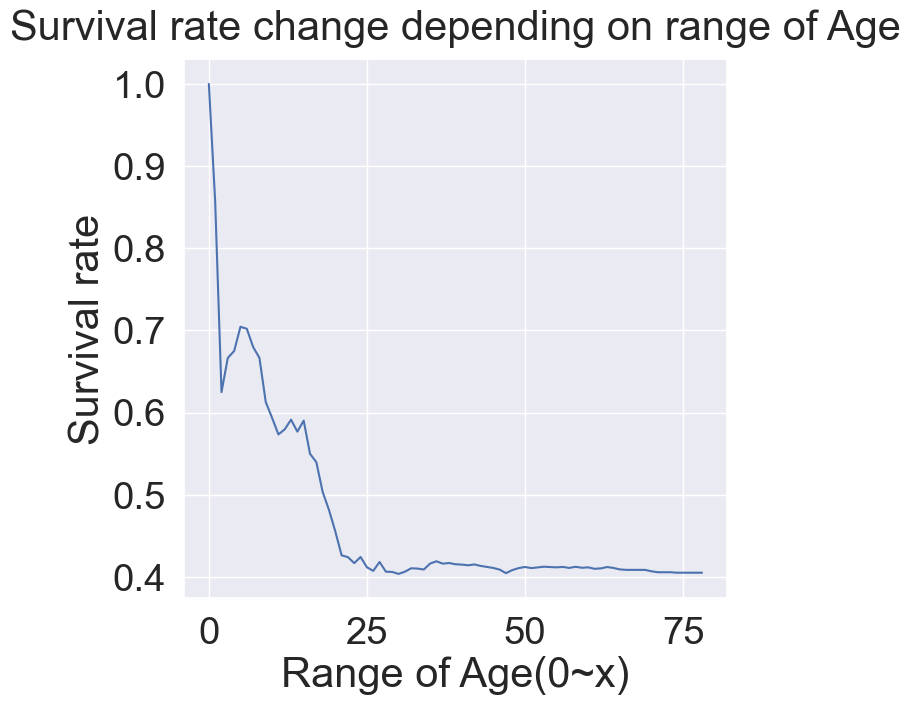

In [24]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age']<i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

* 나이가 어릴 수록 생존률이 확실히 높다
* 나이가 중요한 feature로 쓰일 수 있겠다

## 2.5 Pclass, Sex, Age
* 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해서 보고자 한다.
* x 축은 Pclass, Sex, y축은 Age의 distribution을 나타내보자

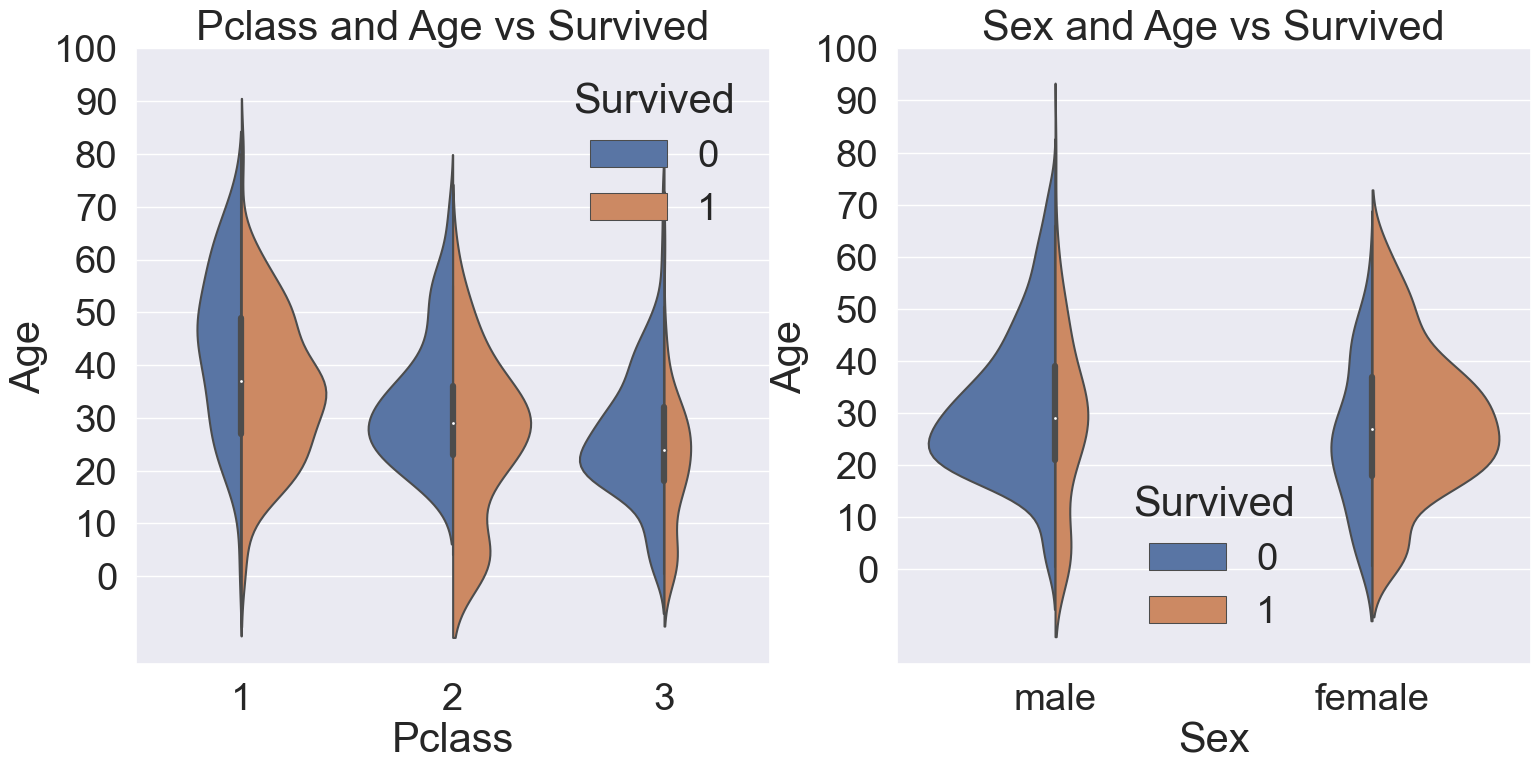

In [25]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot(x='Pclass',y='Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

* 왼쪽 그림은 Pclass별로 Age의 분포가 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프이다.
* 오른쪽 그림도 마찬가지로 Sex, 생존에 따른 분포가 어떻게 다른지 보여주는 그래프.
* 생존만 봤을 때 모든 클래스에서 생존한 나이대가 생존 못한 나이대보다 어린 것을 볼 수 있다.
* 오른쪽 그림을 보면 명확하게 여자가 생존을 많이 한 것을 알 수 있다.
* 여성과 아이를 먼저 챙긴 것을 볼 수 있다.

## Embarked
* 탑승한 항구를 나타냄

<Axes: xlabel='Embarked'>

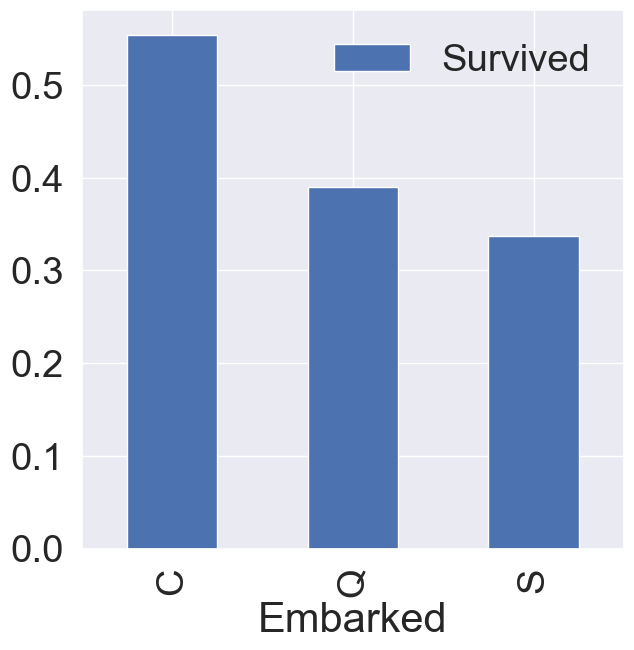

In [28]:
f, ax = plt.subplots(1, 1, figsize=(7,7))
df_train[['Embarked','Survived']].groupby('Embarked',as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax)

* 조금의 차이는 있지만 생존률은 비슷비슷하다. 그나마 C가 제일 높음
* 모델을 만들고 나서 feature들이 얼마나 중요한 역할을 하는지 볼 수 있기 때문에 일단 사용

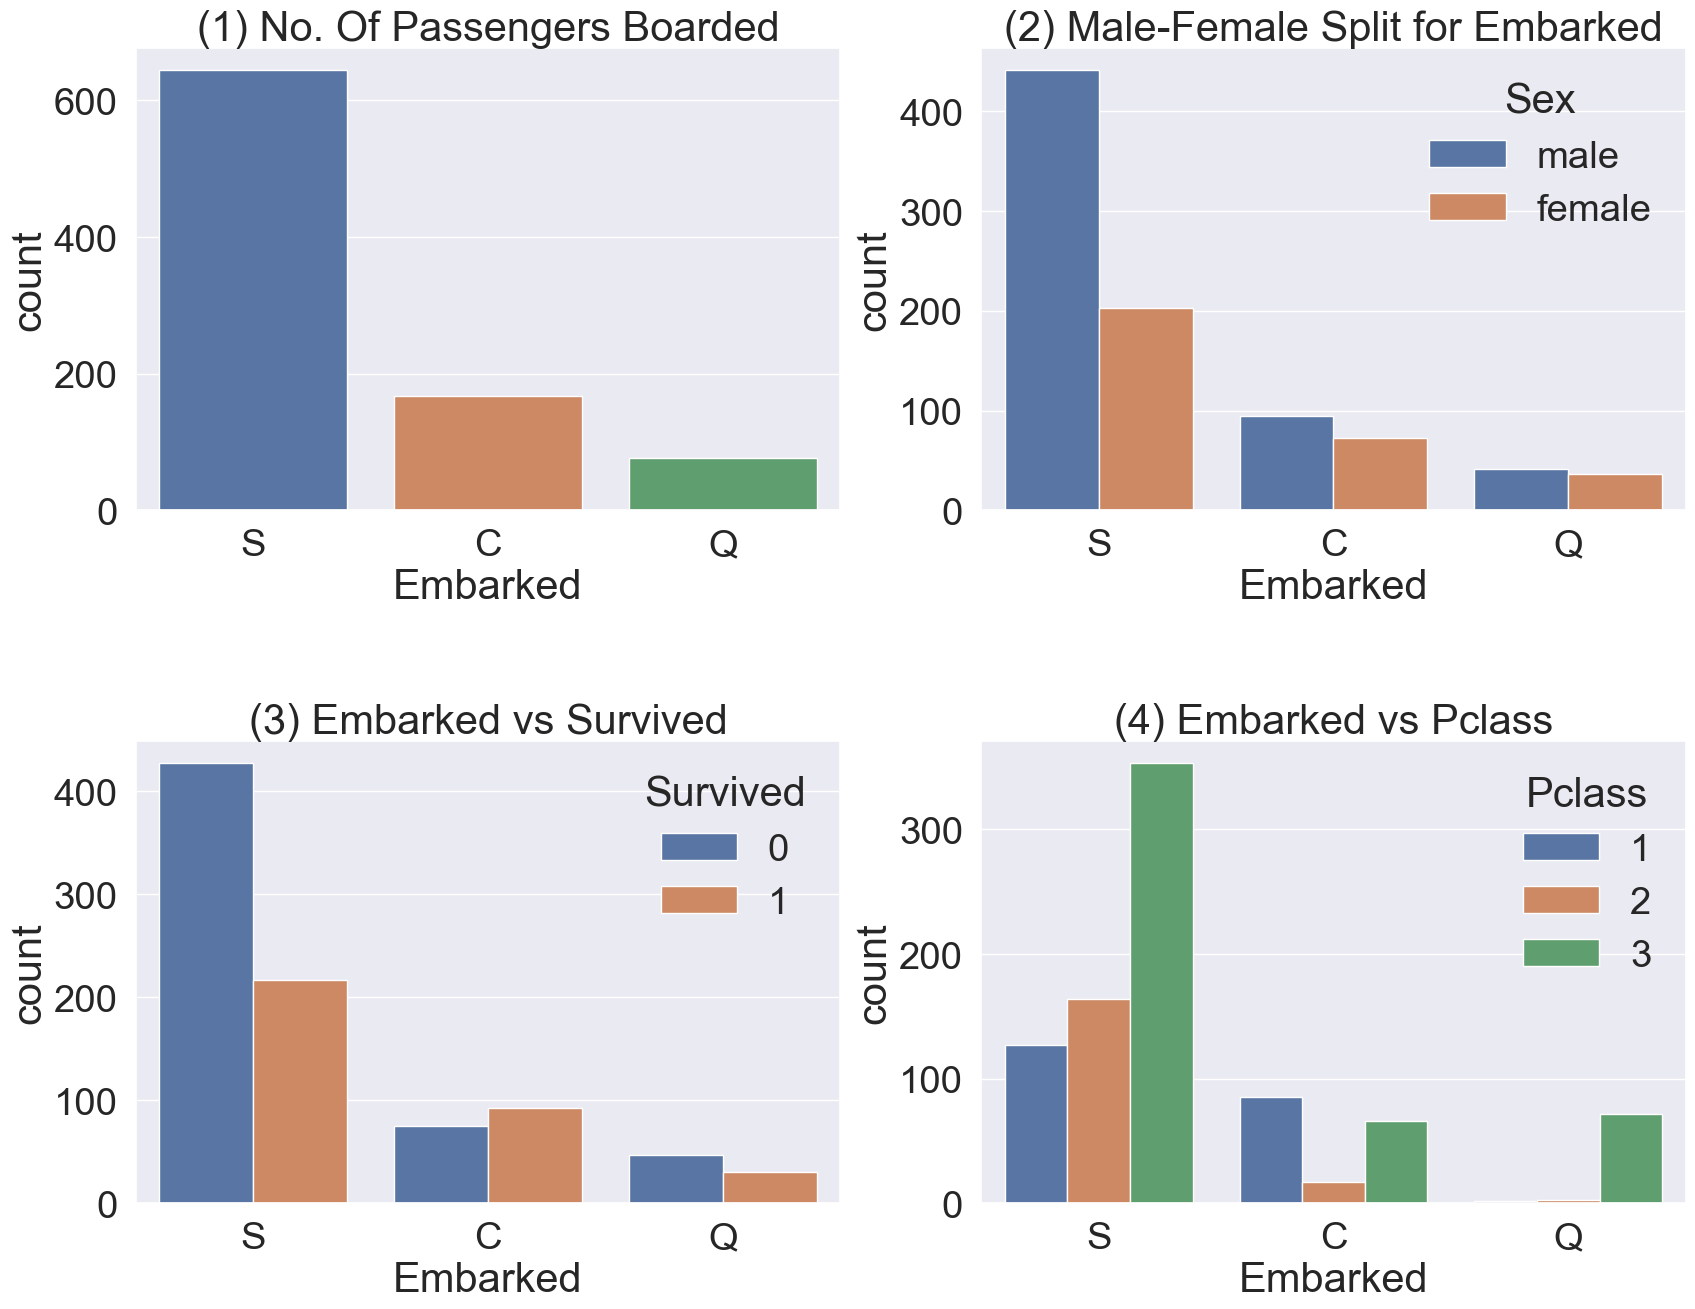

In [33]:
f, ax = plt.subplots(2,2 , figsize=(20,15))
sns.countplot(x='Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')

sns.countplot(x='Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')

sns.countplot(x='Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')

sns.countplot(x='Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 S에서 가장 많은 사람이 탑승했다.
* Figure(2) - C와 Q는 남녀 비율이 비슷하고, S는 남자가 더 많다.
* Figure(3) - 생존확률이 S인경우 낮다
* Figure(4) - C가 생존률이 높았던 이유는 class가 1인 사람이 많이 탔기 때문이다. Q는 class3이 많이 탔기 때문에 생존확률이 낮다.

## 2.7 Family - SibSp(형제자매) + Parch(부모, 자녀)
* SibSp와 Parch를 합치면 Family가 될 것이다. 합쳐서 분석

In [34]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] +1 #자신을 포함해서 1 더해줌
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']

In [35]:
print('Maximum size of Family: ', df_train['FamilySize'].max())
print('Minimum size of Family: ', df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


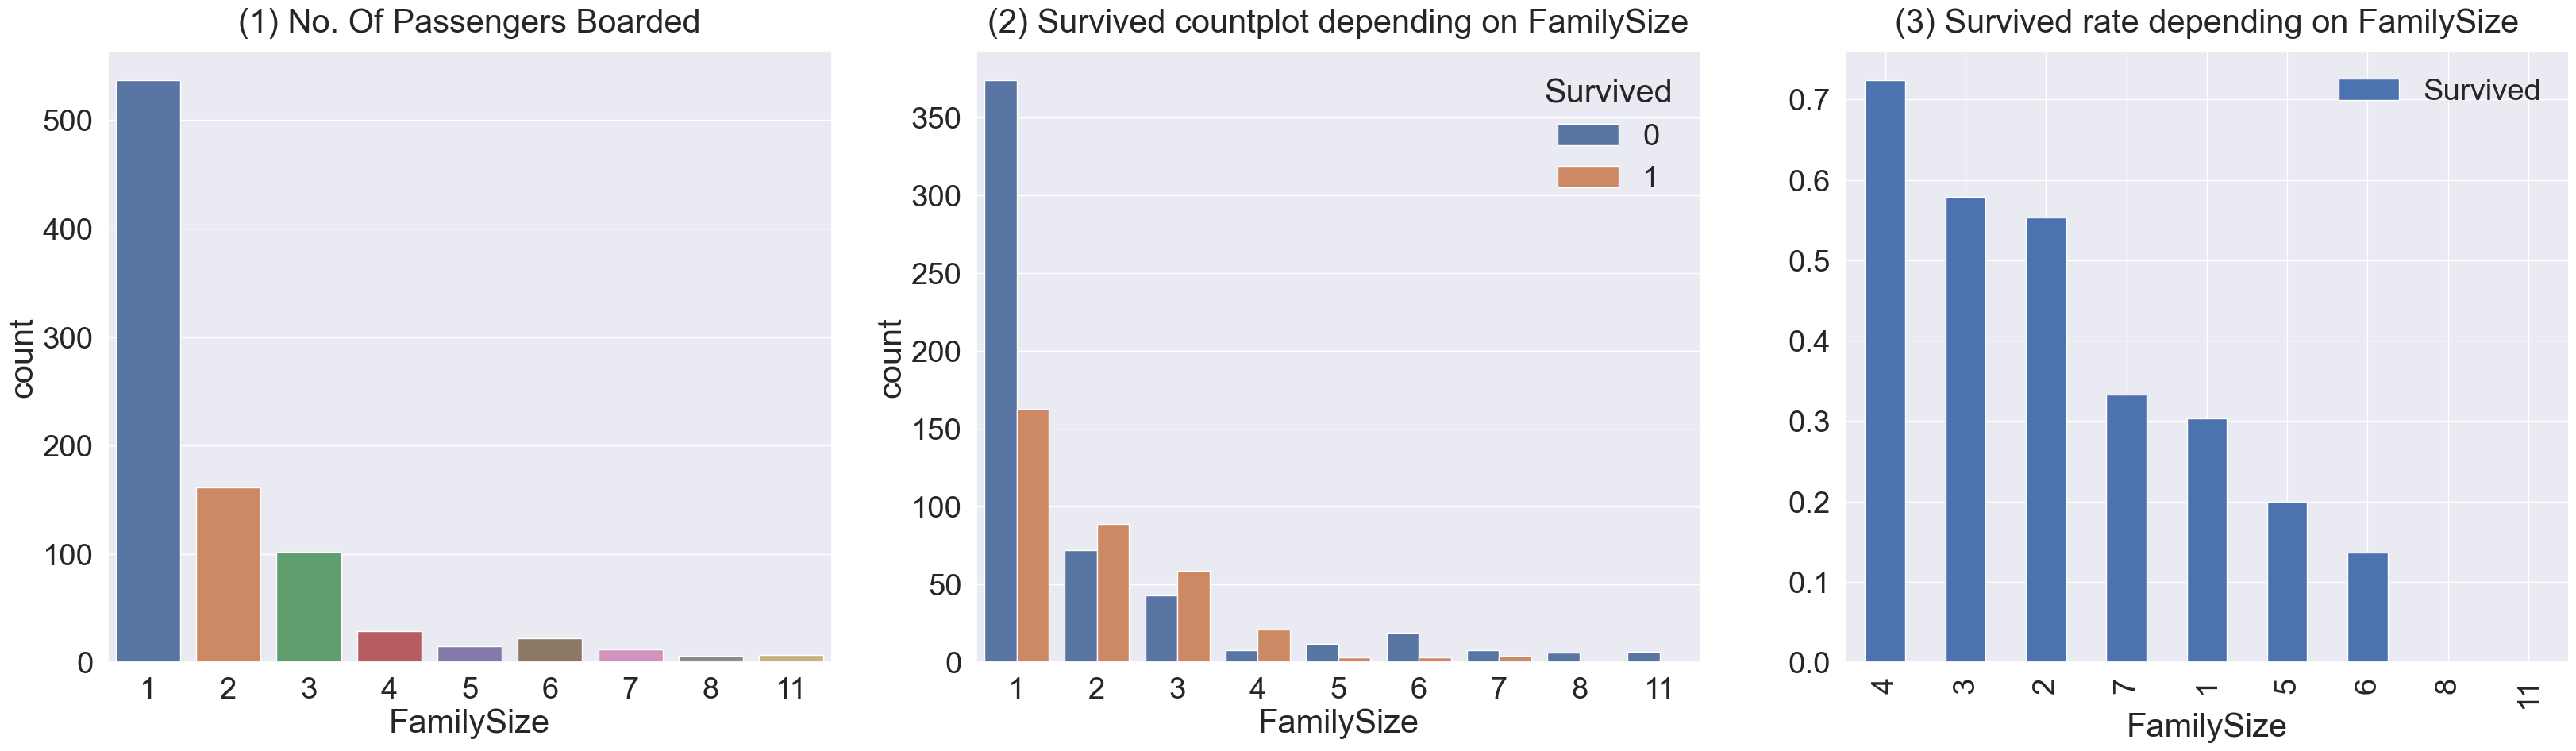

In [38]:
# FamilySize와 생존의 관계
f, ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot(x='FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot(x='FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

df_train[['FamilySize', 'Survived']].groupby('FamilySize', as_index=True).mean().\
                                  sort_values(by='Survived', ascending=False).plot.\
                                  bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

* Figure (1) - 가족크기가 1~11까지 있음 대부분 1명이고 그다음으로 2,3,4명이다.
* Figure (2),(3) - 가족 크기에 따른 생존확률 비교. 가족이 4명인 경우가 생존률이 가장 높다. 가족수가 많아질수록(5,6,7,8,11) 생존확률이 작다. 혼자인 경우도 생존확률이 낮다. 3,4인가족이 생존확률이 높다.

## 2.8 Fare

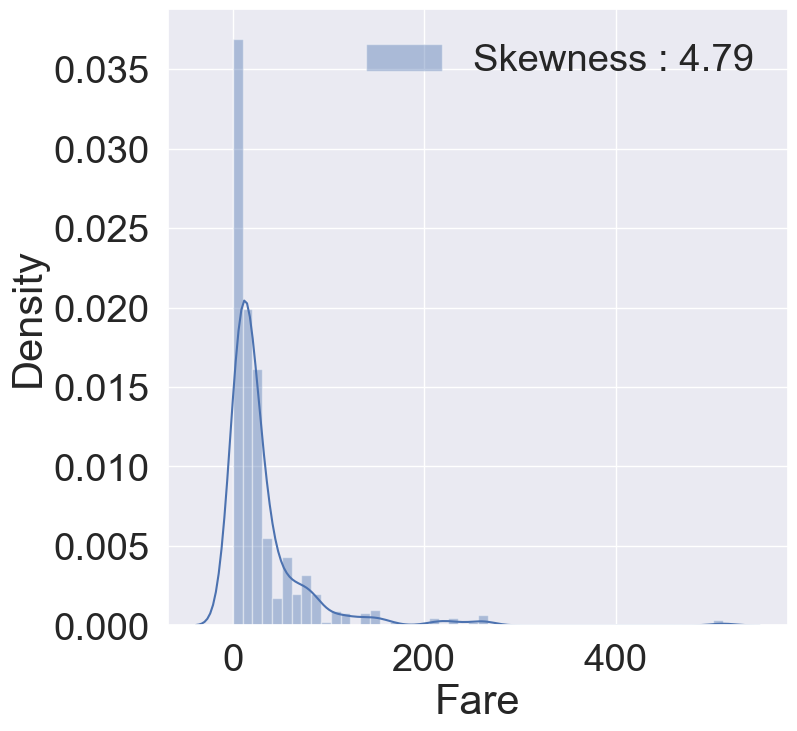

In [39]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* 분포가 매우 비대칭적이다.
* log변환

In [40]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # test set에 있는 결측치를 평균값으로 대치
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

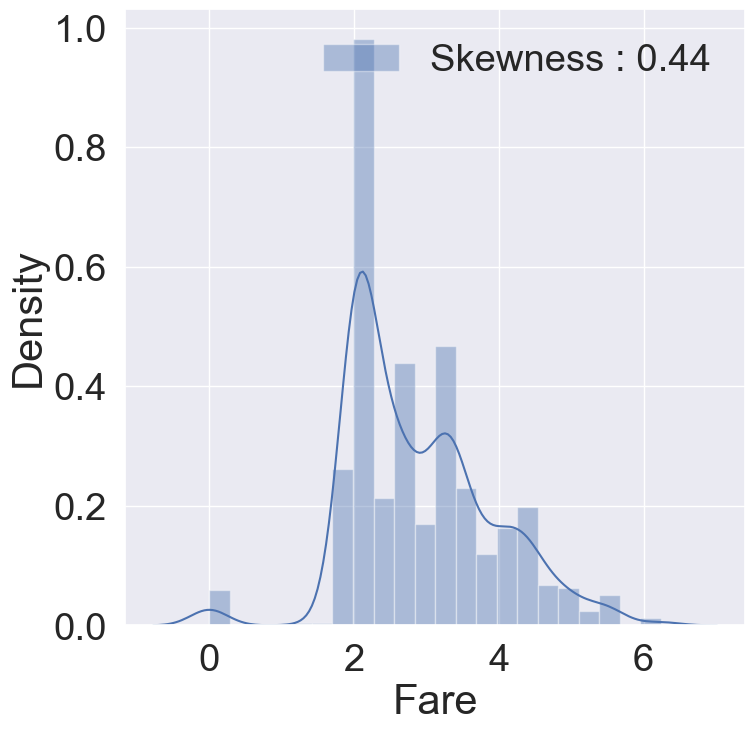

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

* log를 취하니 비대칭성이 많이 사라진 것을 볼수 있다.

## 2.9 Cabin
* 이 Feature는 결칙치가 대략 80%이므로 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않다.
* 그러므로 drop

In [43]:
del df_train['Cabin'], df_test['Cabin']

In [44]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,S,1


In [45]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,2.057860,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,1.945910,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,2.270836,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,2.159003,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,2.508582,S,2


## 2.10 Ticket
* 결측치는 없고 String데이터이므로 어떤 작업들을 해줘야 하는데 이를 위해선 아이디어가 필요하다

In [47]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

# 3. Feature enginerring
* feature engineering 시작
* dataset에 존재하는 결측치부터 채운다.

In [21]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3.1 Fill Null data

### 3.1.1 Fill Null in Age using title
* Age에는 결측치가 177개나 있다. 이를 채우는데 여기서는 title + statistics를 사용
* 영어에는 Miss, Mr, Mrs 같은 title이 존재한다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해 보겠다.

In [22]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') # extract the Salutations
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.') # extract the Salutations

In [23]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


이 테이블을 참고하여 남자, 여자가 쓰는 initial을 구분.

In [24]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [25]:
df_train.groupby('Initial').mean()['Survived']

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

여성과 관련있는 Miss, Mrs가 생존률이 높은 것을 볼 수 있다.

<Axes: xlabel='Initial'>

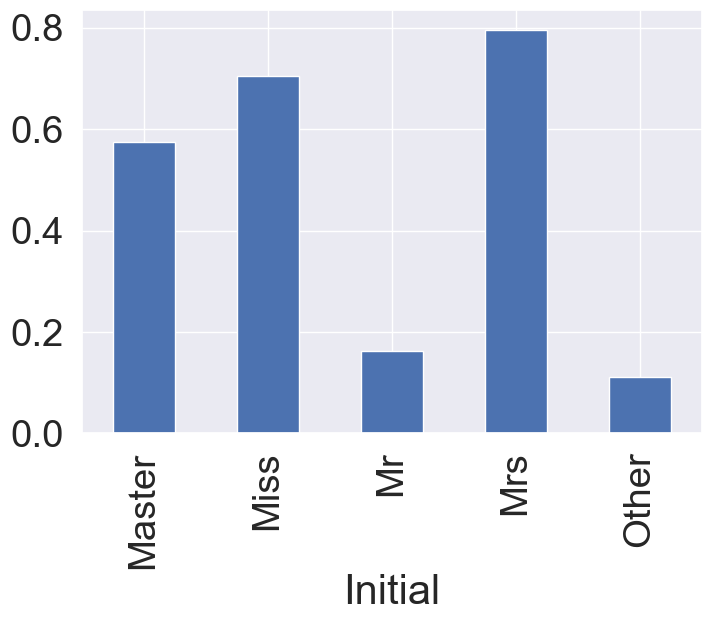

In [26]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* 이제 본격적으로 결측치 채우기. 결측치를 채우는 방법은 정말 많다. statistics를 활용하는 방법도 있고, 결측치가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있다. 여기서는 statistics 활용
* test 데이터는 항상 unseen으로 둬야하기 때문에 train의 statistics를 기반으로 test데이터의 결측치를 채워줘야 한다.

In [27]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [28]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [29]:
print('Embarked has', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has 2  Null values


* Embaked에는 2개의 결측치가 있고 S에서 가장 많은 탑승객이 있었으므로 S로 채워준다.
* fillna method 사용

In [30]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age (countinuous to categorical)
* Age는 현재 continuous feature이다. category 변수로 바꿔주면 정보손실이 일어날 수도 있지만 다양한 방법을 알아보는 취지로 진행한다.
* 첫번째로 loc을 사용한 방법으로 10살간격으로 나눠주기

In [31]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age']<10, 'Age_cat'] = 0
df_train.loc[(df_train['Age']>=10)&(df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(df_train['Age']>=20)&(df_train['Age']<30), 'Age_cat'] = 2
df_train.loc[(df_train['Age']>=30)&(df_train['Age']<40), 'Age_cat'] = 3
df_train.loc[(df_train['Age']>=40)&(df_train['Age']<50), 'Age_cat'] = 4
df_train.loc[(df_train['Age']>=50)&(df_train['Age']<60), 'Age_cat'] = 5
df_train.loc[(df_train['Age']>=60)&(df_train['Age']<70), 'Age_cat'] = 6
df_train.loc[df_train['Age']>=70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age']<10, 'Age_cat'] = 0
df_test.loc[(df_test['Age']>=10)&(df_test['Age']<20), 'Age_cat'] = 1
df_test.loc[(df_test['Age']>=20)&(df_test['Age']<30), 'Age_cat'] = 2
df_test.loc[(df_test['Age']>=30)&(df_test['Age']<40), 'Age_cat'] = 3
df_test.loc[(df_test['Age']>=40)&(df_test['Age']<50), 'Age_cat'] = 4
df_test.loc[(df_test['Age']>=50)&(df_test['Age']<60), 'Age_cat'] = 5
df_test.loc[(df_test['Age']>=60)&(df_test['Age']<70), 'Age_cat'] = 6
df_test.loc[df_test['Age']>=70, 'Age_cat'] = 7

In [32]:
# 두번째로 함수를 만들어 apply메소드에 넣어주는 것
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
df_train['Age_cat2'] = df_train['Age'].apply(category_age)

In [33]:
# 둘다 결과가 같은지 비교
print('1번 방법, 2번방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat']==df_train['Age_cat2']).all())

1번 방법, 2번방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [34]:
# 중복되는 Age_cat 컬럼과 원 컬럼 Age 제거
df_train.drop(['Age', 'Age_cat2'], axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

## 3.3 change initial, embarked and Sex (string to Numerical)
* 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있다. 이를 map method를 가지고 사전순으로 숫자로 매핑

In [35]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

Embarked 또한 같은 방식으로 str에서 numeric으로 변경

In [36]:
print(df_train['Embarked'].unique())
print(df_train['Embarked'].value_counts())

['S' 'C' 'Q']
S    646
C    168
Q     77
Name: Embarked, dtype: int64


In [37]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [38]:
df_train['Embarked'].isnull().any()

False

In [39]:
# Sex 또한 마찬가지로 진행
df_train['Sex'] = df_train['Sex'].map({'female':0,'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0,'male':1})

이제 각 feature간의 상관관계를 살펴보자  
$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$

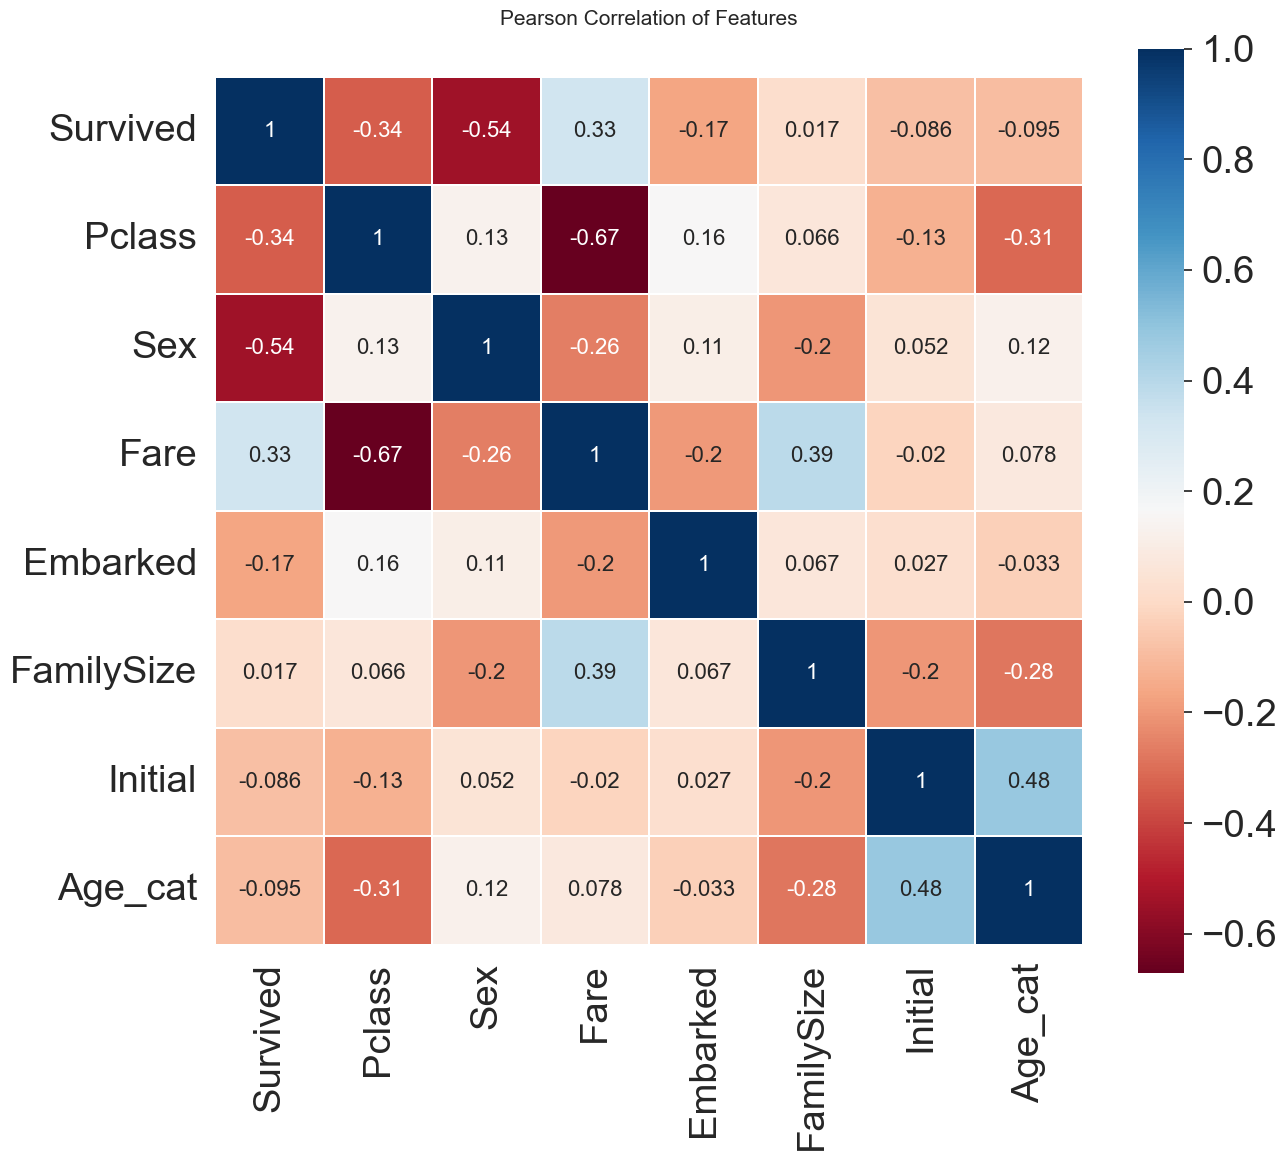

In [40]:
heatmap_data = df_train[['Survived','Pclass','Sex','Fare','Embarked',
                         'FamilySize','Initial','Age_cat']]
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})
del heatmap_data

## 3.4 One-hot encoding on Initial and Embarked
* 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있다.
* 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑

In [41]:
df_train = pd.get_dummies(df_train, columns=['Initial'],prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'],prefix='Initial')

In [42]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [43]:
# Embarked에도 마찬가지로 적용
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

## 3.5 Drop columns

In [44]:
# 필요한 컬럼만 남기기
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [45]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [46]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 4. Building machine learning model and prediction using the trained model

In [47]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics # 모델평가
from sklearn.model_selection import train_test_split # traning set을 나눠줌

## 4.1 Preparation - Split dataset into train, valid and test set

In [48]:
# 학습에 쓰일 데이터, target 분리
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [49]:
# train, valid 분리
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

## 4.2 Model generation and prediction

In [50]:
# 모델 학습
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [51]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.84% 정확도로 생존을 맞춤


## 4.3 Feature importance

In [52]:
feature_importance = model.feature_importances_
Series_feat_imp = pd.Series(feature_importance, index=df_test.columns)

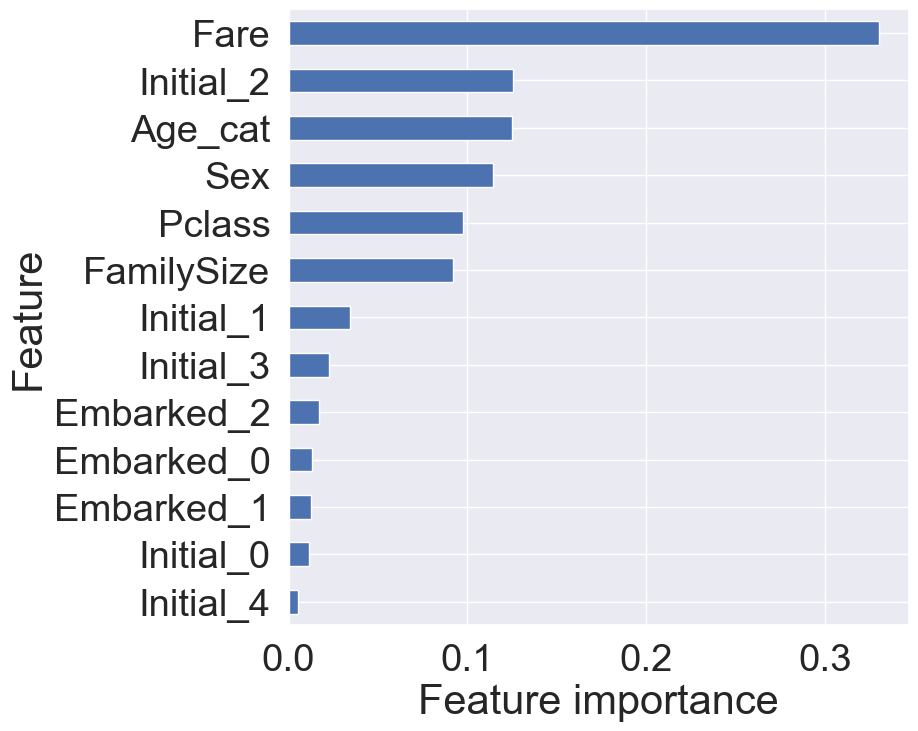

In [53]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

* 우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가진다.

* 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있다.
* 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴봐야 한다.
* featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있다.